# Implementation

## Importing libraries


In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D
# --------------------------added
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, GRU, SimpleRNN 
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Embedding, Dropout, Activation, Input
from keras.models import Model
# ------------------------added end
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import gc
import matplotlib.pyplot as plt
%matplotlib inline

## Mouning Google drive

In [2]:
from google.colab import drive
drive.mount('/Mydrive')

Mounted at /Mydrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read train data file

In [4]:
%cd /content/drive/MyDrive
!pwd

/content/drive/MyDrive
/content/drive/MyDrive


In [5]:
data_sh1 = pd.read_excel('Deep_Learning_HW4/Labeled_Sentences.xlsx', sheet_name='Sheet1')
data_sh2 = pd.read_excel('Deep_Learning_HW4/Labeled_Sentences.xlsx', sheet_name='Sheet2')
data1 = data_sh1[['review','label']] 
data2 = data_sh2[['review','label']] 
data = pd.concat([data1, data2])
print(data.describe)

<bound method NDFrame.describe of                                                 review  label
0    سلام من یک ماه پیش در هتل شمس قشم بودم واقعا ه...      2
1    سلام بنده با همراه خانوادم چهار روز در این هتل...      2
2    ما از تاریخ ۵اسفند ۹۶تا۸اسفند ۹۶ در این هتل اق...      2
3    من 2روز در اين هتل به همراه همسرم اقامت داشتم ...      2
4    سفر بسیار خوبی بود هتل بسیار زیبا و قشنگی بود ...      2
..                                                 ...    ...
698      هتل بسيار تميز و داراي استانداردهاي روز دنيا       2
699                                 طراحي مدرن و عالي       2
700                 پرسنل آموزش ديده جوان و تحصيلكرده       2
701                           اتاقهاي فوق العاده تميز       2
702             . من واقعا أقامت آرامي را تجربه كردم .      2

[1633 rows x 2 columns]>


### difinition for label of training dataset

In [6]:
list_classes_name = ['Negative', 'Neutral', 'Positive']
list_classes = [0, 1, 2]
list_columns = ['review','label']

In [7]:
print('Positive:',data[ data['label'] == 2].size)
print('Negative:',data[ data['label'] == 0].size)
print('Neutral:',data[ data['label'] == 1].size)

Positive: 2406
Negative: 528
Neutral: 332


prepare data


In [8]:
max_features = 70000
data['review'] = data['review'].apply(str)
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['review'].values)
X = tokenizer.texts_to_sequences(data['review'].values)

In [9]:
print(X[4:5])
print(data['review'].values[4:5])

[[71, 12, 41, 3, 2, 12, 63, 1, 637, 3, 1, 10, 6, 17, 212, 204, 498, 324, 102, 1, 63, 281, 203]]
['سفر بسیار خوبی بود هتل بسیار زیبا و قشنگی بود و من از اقامت خود لذت بردم اتاقهای شیک و زیبا- غذاهای متنوع']


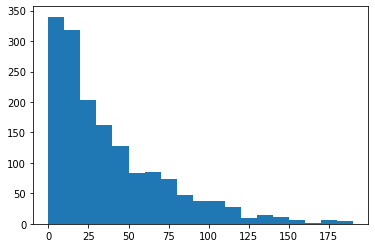

1076


In [10]:
totalNumWords = [len(one_comment) for one_comment in X]
plt.hist(totalNumWords,bins = np.arange(0,200,10))
plt.show()
print(sorted(totalNumWords)[-1])

In [11]:
# for i in range(len(data['review'])):
#   if len(X[i]) >= 170:
#     print(data['review'][i])
#     break

In [12]:
maxlen = 170
X = pad_sequences(X, maxlen=maxlen)

In [13]:
# label encodeing
from tensorflow.keras.utils import to_categorical
X_t=np.asarray(X).astype(np.float32)
# y -> one hot codeing 
y = np.array(data['label'])
y = to_categorical(y, 3, dtype="float32")
print(X_t.shape,y.shape)

(1633, 170) (1633, 3)


In [14]:
y[4]

array([0., 0., 1.], dtype=float32)

##  load our embeddings model into a dictionary 

In [15]:
%cd Deep_Learning_HW4
!pwd

/content/drive/MyDrive/Deep_Learning_HW4
/content/drive/MyDrive/Deep_Learning_HW4


In [16]:
# !wget https://github.com/Text-Mining/Persian-Wikipedia-Corpus/raw/master/models/glove/vectors.zip

In [17]:
# !unzip vectors.zip

In [18]:
def prepare_sentence_to_vector(sent):
  X = tokenizer.texts_to_sequences(sent)
  X = pad_sequences(X, maxlen=maxlen)
  X_t=np.asarray(X).astype(np.float32)
  return X_t


In [19]:
def embedding_layer():
  embeddings_dict = {}
  with open("vectors.txt", 'r', encoding="utf-8") as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  gc.collect()
  #We get the mean and standard deviation of the embedding weights so that we could maintain the 
  #same statistics for the rest of our own random generated weights. 
  all_embs = np.stack(list(embeddings_dict.values()))
  emb_mean,emb_std = all_embs.mean(), all_embs.std()
          
  nb_words = len(tokenizer.word_index) + 1
  #We are going to set the embedding size to the pretrained dimension as we are replicating it.
  #the size will be Number of Words in Vocab X Embedding Size
  embed_size = 50
  embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
  gc.collect()

  #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
  #our own dictionary and loaded pretrained embedding. 
  embeddedCount = 0
  for word, i in tokenizer.word_index.items():
    #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    embedding_vector = embeddings_dict.get(word)
    #and store inside the embedding matrix that we will train later on.
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        embeddedCount+=1
  print('total embedded:',embeddedCount,'common words')
          
  del(embeddings_dict)
  gc.collect()

  return embedding_matrix


  

In [20]:
embedding_matrix = embedding_layer()

total embedded: 4751 common words


# training steps

## building your models

Early stopping callback:

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [23]:
from sklearn.model_selection import train_test_split

In [25]:
len(tokenizer.word_index)

7928

#structure of models

##single LSTM layer model

In [34]:
# from keras.models import Sequential
model1 = Sequential()
model1.add(Input(shape=(maxlen, )))
model1.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model1.add(LSTM(32,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model1.add(GlobalMaxPool1D())

model1.add(Dense(32, activation="relu"))
model1.add(Dropout(0.1))

model1.add(Dense(3, activation="softmax"))

model1.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model1.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 170, 50)           396450    
_________________________________________________________________
lstm_layer (LSTM)            (None, 170, 32)           10624     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 408,229
Trainable params: 11,779
Non-trainable params: 396,450
___________________________________________

##Two LSTM layer model

In [ ]:
# from keras.models import Sequential
model2 = Sequential()
model2.add(Input(shape=(maxlen, )))
model2.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model2.add(LSTM(32,name='lstm_layer_1',dropout=0.2,recurrent_dropout=0.2, return_sequences=True,  activation='tanh'))
model2.add(LSTM(32,name='lstm_layer_2',dropout=0.2,recurrent_dropout=0.2, return_sequences=True, activation='tanh'))

model2.add(GlobalMaxPool1D())

model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.1))

model2.add(Dense(3, activation="softmax"))

model2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 170, 50)           396450    
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 170, 32)           10624     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 170, 32)           8320      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

##Four LSTM layer model

In [26]:
# from keras.models import Sequential
model3 = Sequential()
model3.add(Input(shape=(maxlen, )))
model3.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model3.add(LSTM(50,name='lstm_layer_1',dropout=0.2,recurrent_dropout=0.2, return_sequences=True, activation='tanh'))
model3.add(LSTM(50,name='lstm_layer_2',dropout=0.2,recurrent_dropout=0.2, return_sequences=True,activation='tanh'))
model3.add(LSTM(50,name='lstm_layer_3',dropout=0.3,recurrent_dropout=0.3, return_sequences=True,activation='tanh'))
model3.add(LSTM(50,name='lstm_layer_4',dropout=0.4,recurrent_dropout=0.4, return_sequences=True,activation='tanh'))

model3.add(GlobalMaxPool1D())

model3.add(Dense(32, activation="relu"))
model3.add(Dropout(0.1))

model3.add(Dense(3, activation="softmax"))

model3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 170, 50)           396450    
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 170, 32)           10624     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 170, 32)           8320      
_________________________________________________________________
lstm_layer_3 (LSTM)          (None, 170, 64)           24832     
_________________________________________________________________
lstm_layer_4 (LSTM)          (None, 170, 64)           33024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

##Six LSTM layer model

In [48]:
# from keras.models import Sequential
model4 = Sequential()
model4.add(Input(shape=(maxlen, )))
model4.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model4.add(LSTM(50,name='lstm_layer_1',dropout=0.2,recurrent_dropout=0.2, return_sequences=True, activation='relu'))
model4.add(LSTM(50,name='lstm_layer_2',dropout=0.2,recurrent_dropout=0.2, return_sequences=True,activation='relu'))
model4.add(LSTM(50,name='lstm_layer_3',dropout=0.3,recurrent_dropout=0.3, return_sequences=True,activation='relu'))
model4.add(LSTM(50,name='lstm_layer_4',dropout=0.4,recurrent_dropout=0.4, return_sequences=True,activation='tanh'))
model4.add(LSTM(50,name='lstm_layer_5',dropout=0.5,recurrent_dropout=0.5, return_sequences=True,activation='tanh'))
model4.add(LSTM(50,name='lstm_layer_6',dropout=0.6,recurrent_dropout=0.6, return_sequences=True,activation='tanh'))


model4.add(GlobalMaxPool1D())

model4.add(Dense(32, activation="relu"))
model4.add(Dropout(0.1))

model4.add(Dense(3, activation="softmax"))

model4.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model4.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 170, 50)           396450    
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 170, 50)           20200     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 170, 50)           20200     
_________________________________________________________________
lstm_layer_3 (LSTM)          (None, 170, 50)           20200     
_________________________________________________________________
lstm_layer_4 (LSTM)          (None, 170, 50)           20200     
_________________________________________________________________
lstm_layer_5 (LSTM)          (None, 170, 50)           20200     
_________________________________________________________________
lstm_layer_6 (LSTM)          (None, 170, 50)          

##Bidirectional LSTM model

In [32]:
# from keras.models import Sequential
model5 = Sequential()
model5.add(Input(shape=(maxlen, )))
model5.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model5.add(Bidirectional(LSTM(32,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model5.add(GlobalMaxPool1D())

model5.add(Dense(32, activation="relu"))
model5.add(Dropout(0.1))

model5.add(Dense(3, activation="softmax"))

model5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model5.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 170, 50)           396450    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 170, 64)           21248     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 419,877
Trainable params: 23,427
Non-trainable params: 396,450
___________________________________________

##CNN model

In [ ]:
from tensorflow.keras import regularizers
model6 = Sequential()
model6.add(Input(shape=(maxlen, )))
model6.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model6.add(Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model6.add(MaxPooling1D(5))

model6.add(Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model6.add(GlobalMaxPooling1D())

model6.add(Dense(3,activation='softmax'))
model6.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model6.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 170, 50)           396450    
_________________________________________________________________
conv1d (Conv1D)              (None, 165, 20)           6020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 20)            2420      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 63        
Total params: 404,953
Trainable params: 8,503
Non-trainable params: 396,450
___________________________________________

#model training

In [27]:
import matplotlib.pyplot as plt
def plot_result(hist):
  # Loss plot for model
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title("Loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # Accuracy plot
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title("Accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

##single LSTM layer model

In [36]:
batch_size = 256
epochs = 150
hist = model1.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/150
6/6 [==============================] - 4s 673ms/step - loss: 0.7949 - accuracy: 0.7198 - val_loss: 0.6637 - val_accuracy: 0.8012
Epoch 2/150
6/6 [==============================] - 4s 679ms/step - loss: 0.7880 - accuracy: 0.7205 - val_loss: 0.6573 - val_accuracy: 0.8012
Epoch 3/150
6/6 [==============================] - 4s 691ms/step - loss: 0.7848 - accuracy: 0.7205 - val_loss: 0.6504 - val_accuracy: 0.8012
Epoch 4/150
6/6 [==============================] - 4s 663ms/step - loss: 0.7738 - accuracy: 0.7205 - val_loss: 0.6432 - val_accuracy: 0.8012
Epoch 5/150
6/6 [==============================] - 4s 689ms/step - loss: 0.7636 - accuracy: 0.7213 - val_loss: 0.6361 - val_accuracy: 0.8012
Epoch 6/150
6/6 [==============================] - 4s 686ms/step - loss: 0.7582 - accuracy: 0.7205 - val_loss: 0.6223 - val_accuracy: 0.8012
Epoch 7/150
6/6 [==============================] - 4s 689ms/step - loss: 0.7545 - accuracy: 0.7205 - val_loss: 0.6103 - val_accuracy: 0.8012
Epoch 8/150
6

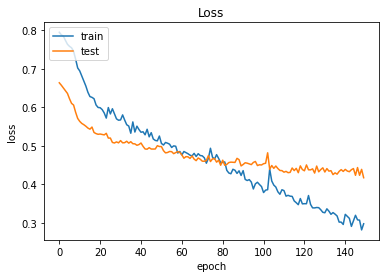

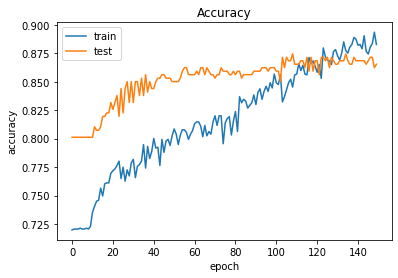

In [41]:
plot_result(hist)

##Two LSTM layer model

In [ ]:
batch_size = 256
epochs = 150
hist2 = model2.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/150
6/6 [==============================] - 18s 2s/step - loss: 1.1066 - accuracy: 0.2411 - val_loss: 1.0288 - val_accuracy: 0.8012
Epoch 2/150
6/6 [==============================] - 8s 1s/step - loss: 1.0000 - accuracy: 0.7166 - val_loss: 0.9326 - val_accuracy: 0.8012
Epoch 3/150
6/6 [==============================] - 8s 1s/step - loss: 0.9124 - accuracy: 0.7242 - val_loss: 0.8262 - val_accuracy: 0.8012
Epoch 4/150
6/6 [==============================] - 8s 1s/step - loss: 0.8510 - accuracy: 0.7139 - val_loss: 0.7362 - val_accuracy: 0.8012
Epoch 5/150
6/6 [==============================] - 8s 1s/step - loss: 0.8304 - accuracy: 0.7129 - val_loss: 0.6860 - val_accuracy: 0.8012
Epoch 6/150
6/6 [==============================] - 9s 1s/step - loss: 0.8328 - accuracy: 0.7174 - val_loss: 0.6730 - val_accuracy: 0.8012
Epoch 7/150
6/6 [==============================] - 9s 1s/step - loss: 0.8285 - accuracy: 0.7133 - val_loss: 0.6749 - val_accuracy: 0.8012
Epoch 8/150
6/6 [================

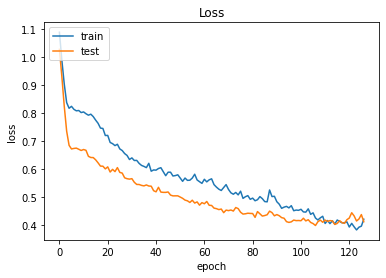

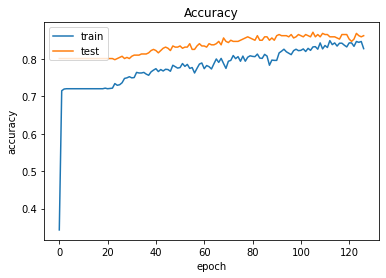

In [ ]:
plot_result(hist2)

##Four LSTM layer model

In [ ]:
batch_size = 256
epochs = 150
hist3 = model3.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/150
6/6 [==============================] - 32s 3s/step - loss: 1.0264 - accuracy: 0.6718 - val_loss: 0.9054 - val_accuracy: 0.8012
Epoch 2/150
6/6 [==============================] - 17s 3s/step - loss: 0.8943 - accuracy: 0.7218 - val_loss: 0.8084 - val_accuracy: 0.8012
Epoch 3/150
6/6 [==============================] - 17s 3s/step - loss: 0.8620 - accuracy: 0.7088 - val_loss: 0.7725 - val_accuracy: 0.8012
Epoch 4/150
6/6 [==============================] - 17s 3s/step - loss: 0.8316 - accuracy: 0.7207 - val_loss: 0.7169 - val_accuracy: 0.8012
Epoch 5/150
6/6 [==============================] - 17s 3s/step - loss: 0.8163 - accuracy: 0.7223 - val_loss: 0.6971 - val_accuracy: 0.8012
Epoch 6/150
6/6 [==============================] - 17s 3s/step - loss: 0.7992 - accuracy: 0.7242 - val_loss: 0.6679 - val_accuracy: 0.8012
Epoch 7/150
6/6 [==============================] - 17s 3s/step - loss: 0.7807 - accuracy: 0.7245 - val_loss: 0.6561 - val_accuracy: 0.8012
Epoch 8/150
6/6 [==========

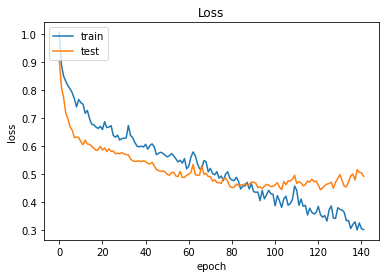

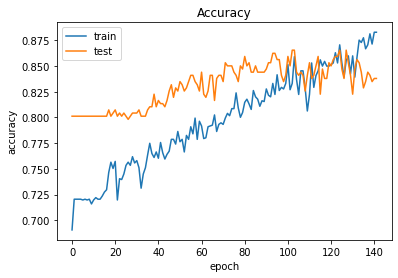

In [ ]:
plot_result(hist3)

##Six LSTM layer model

In [57]:
batch_size = 512
epochs = 150
hist4 = model4.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/150
3/3 [==============================] - 13s 4s/step - loss: 0.7613 - accuracy: 0.7205 - val_loss: 0.6286 - val_accuracy: 0.8012
Epoch 2/150
3/3 [==============================] - 13s 4s/step - loss: 0.7665 - accuracy: 0.7205 - val_loss: 0.6277 - val_accuracy: 0.8012
Epoch 3/150
3/3 [==============================] - 13s 4s/step - loss: 0.7584 - accuracy: 0.7205 - val_loss: 0.6260 - val_accuracy: 0.8012
Epoch 4/150
3/3 [==============================] - 13s 4s/step - loss: 0.7605 - accuracy: 0.7205 - val_loss: 0.6259 - val_accuracy: 0.8012
Epoch 5/150
3/3 [==============================] - 13s 4s/step - loss: 0.7619 - accuracy: 0.7205 - val_loss: 0.6265 - val_accuracy: 0.8012
Epoch 6/150
3/3 [==============================] - 13s 4s/step - loss: 0.7652 - accuracy: 0.7205 - val_loss: 0.6271 - val_accuracy: 0.8012
Epoch 7/150
3/3 [==============================] - 13s 4s/step - loss: 0.7577 - accuracy: 0.7205 - val_loss: 0.6277 - val_accuracy: 0.8012
Epoch 8/150
3/3 [==========

In [53]:
batch_size = 256
epochs = 150
hist4 = model4.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/150
6/6 [==============================] - 25s 4s/step - loss: 0.7678 - accuracy: 0.7205 - val_loss: 0.6316 - val_accuracy: 0.8012
Epoch 2/150
6/6 [==============================] - 25s 4s/step - loss: 0.7690 - accuracy: 0.7205 - val_loss: 0.6304 - val_accuracy: 0.8012
Epoch 3/150
6/6 [==============================] - 25s 4s/step - loss: 0.7636 - accuracy: 0.7213 - val_loss: 0.6323 - val_accuracy: 0.8012
Epoch 4/150
6/6 [==============================] - 25s 4s/step - loss: 0.7591 - accuracy: 0.7205 - val_loss: 0.6347 - val_accuracy: 0.8012
Epoch 5/150
6/6 [==============================] - 25s 4s/step - loss: 0.7583 - accuracy: 0.7205 - val_loss: 0.6331 - val_accuracy: 0.8012
Epoch 6/150
6/6 [==============================] - 25s 4s/step - loss: 0.7656 - accuracy: 0.7205 - val_loss: 0.6343 - val_accuracy: 0.8012
Epoch 7/150
6/6 [==============================] - 25s 4s/step - loss: 0.7665 - accuracy: 0.7205 - val_loss: 0.6317 - val_accuracy: 0.8012
Epoch 8/150
6/6 [==========

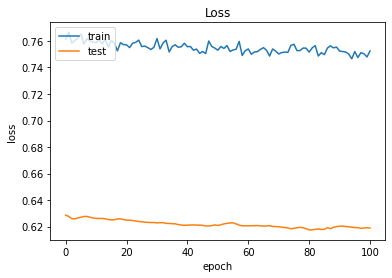

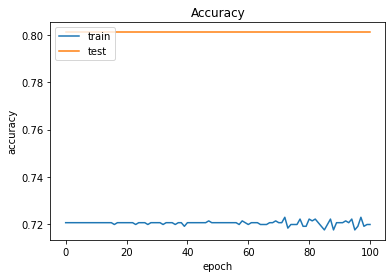

In [58]:
plot_result(hist4)

##Bidirectional LSTM model

In [33]:
batch_size = 256
epochs = 150
hist5 = model5.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/150
6/6 [==============================] - 19s 2s/step - loss: 1.1000 - accuracy: 0.2978 - val_loss: 0.8584 - val_accuracy: 0.7982
Epoch 2/150
6/6 [==============================] - 8s 1s/step - loss: 0.8651 - accuracy: 0.7150 - val_loss: 0.7107 - val_accuracy: 0.8012
Epoch 3/150
6/6 [==============================] - 8s 1s/step - loss: 0.8307 - accuracy: 0.7218 - val_loss: 0.6784 - val_accuracy: 0.8012
Epoch 4/150
6/6 [==============================] - 8s 1s/step - loss: 0.8121 - accuracy: 0.7251 - val_loss: 0.6779 - val_accuracy: 0.8012
Epoch 5/150
6/6 [==============================] - 8s 1s/step - loss: 0.8116 - accuracy: 0.7174 - val_loss: 0.6881 - val_accuracy: 0.8012
Epoch 6/150
6/6 [==============================] - 8s 1s/step - loss: 0.8004 - accuracy: 0.7217 - val_loss: 0.6784 - val_accuracy: 0.8012
Epoch 7/150
6/6 [==============================] - 8s 1s/step - loss: 0.7975 - accuracy: 0.7212 - val_loss: 0.6606 - val_accuracy: 0.8012
Epoch 8/150
6/6 [================

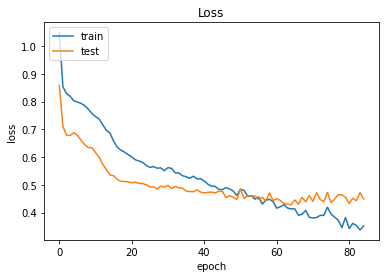

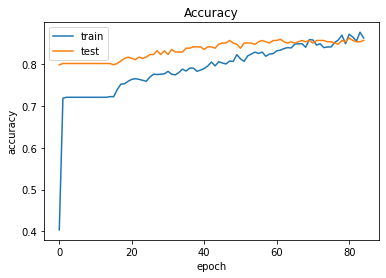

In [40]:
plot_result(hist5)

##CNN model

In [ ]:
batch_size = 256
epochs = 150
hist6 = model6.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[early_stop])

Epoch 1/150
6/6 [==============================] - 44s 192ms/step - loss: 2.1254 - accuracy: 0.7022 - val_loss: 1.8267 - val_accuracy: 0.8012
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 1.9514 - accuracy: 0.7263 - val_loss: 1.7774 - val_accuracy: 0.8012
Epoch 3/150
6/6 [==============================] - 0s 9ms/step - loss: 1.9107 - accuracy: 0.7193 - val_loss: 1.7650 - val_accuracy: 0.8012
Epoch 4/150
6/6 [==============================] - 0s 9ms/step - loss: 1.8494 - accuracy: 0.7168 - val_loss: 1.7379 - val_accuracy: 0.8012
Epoch 5/150
6/6 [==============================] - 0s 9ms/step - loss: 1.7698 - accuracy: 0.7379 - val_loss: 1.6877 - val_accuracy: 0.8012
Epoch 6/150
6/6 [==============================] - 0s 9ms/step - loss: 1.7704 - accuracy: 0.7225 - val_loss: 1.6432 - val_accuracy: 0.8012
Epoch 7/150
6/6 [==============================] - 0s 13ms/step - loss: 1.7018 - accuracy: 0.7235 - val_loss: 1.6094 - val_accuracy: 0.8012
Epoch 8/150
6/6 [=====

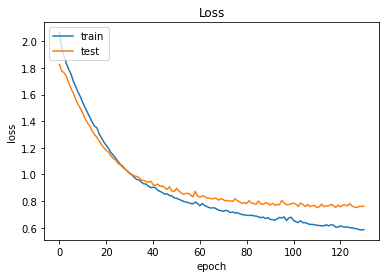

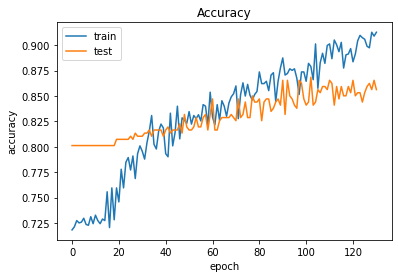

In [ ]:
plot_result(hist6)

#Test models

In [ ]:
def predict_model(sent, model):
  # sent = ['چه بد']
  vect = prepare_sentence_to_vector(sent)
  result = model.predict(vect.reshape(1,X_t.shape[1]),batch_size=1,verbose = 2)
  s = list_classes[np.around(result, decimals=0).argmax(axis=1)[0]]
  print("our model predication: ", list_classes_name[s])

In [ ]:
sent = ['چه خوب']
predict_model(sent, model1)

1/1 - 1s
our model predication:  Positive


In [ ]:
# i =58
# print(data['review'].values[i])
# # print(X_t[30])
# print("The Label: ", data['label'].values[i])
# result = model.predict(X_t[i].reshape(1,X_t.shape[1]),batch_size=1,verbose = 2)
# s = list_classes[np.around(result, decimals=0).argmax(axis=1)[0]]
# print("our model predication: ", list_classes_name[s])

من هم اكنون در هتل اقامت دارم و با اينكه دربرخي هتل هاي لوكس ايران اقامت داشتم،نظافت و تميزي،برخورد كاركنان آموزش ديده،غذا،قيمت مناسب اقامت و رسيدگي رو در حد بسيار مطلوب ميدونم و براي سفرهاي بعدي حتما اين هتل رو انتخاب خواهم كرد..
The Label:  2
1/1 - 0s
our model predication:  Positive


biLSTM + !pretrain model

##training/validation loss plots

In [ ]:
all_losses = {
'one_lstm_loss': hist.history['loss'],
'one_lstm_val_loss': hist.history['val_loss'],
'two_lstm_loss': hist2.history['loss'],
'two_lstm_val_loss': hist2.history['val_loss'],
'four_lstm_loss': hist3.history['loss'],
'four_lstm_val_loss': hist3.history['val_loss'],
'six_lstm_loss': hist4.history['loss'],
'six_lstm_val_loss': hist4.history['val_loss'],
'bi_lstm_loss': hist5.history['loss'],
'bi_lstm_val_loss': hist5.history['val_loss'],
'cnn_loss': hist6.history['loss'],
'cnn_val_loss': hist6.history['val_loss'],
}

In [ ]:
for a in all_losses:
  print(len(all_losses[a]))
  # print(len(all_losses[a]))

50
50
50
50
50
50
50
50
50
50
50
50


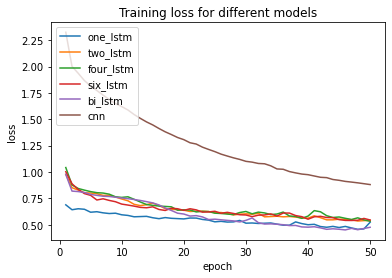

In [ ]:
epochRange = np.arange(1,51,1)
plt.plot(epochRange,all_losses['one_lstm_loss'])
plt.plot(epochRange,all_losses['two_lstm_loss'])
plt.plot(epochRange,all_losses['four_lstm_loss'])
plt.plot(epochRange,all_losses['six_lstm_loss'])
plt.plot(epochRange,all_losses['bi_lstm_loss'])
plt.plot(epochRange,all_losses['cnn_loss'])
plt.title('Training loss for different models')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['one_lstm','two_lstm','four_lstm','six_lstm','bi_lstm','cnn'], loc='upper left')
plt.show()

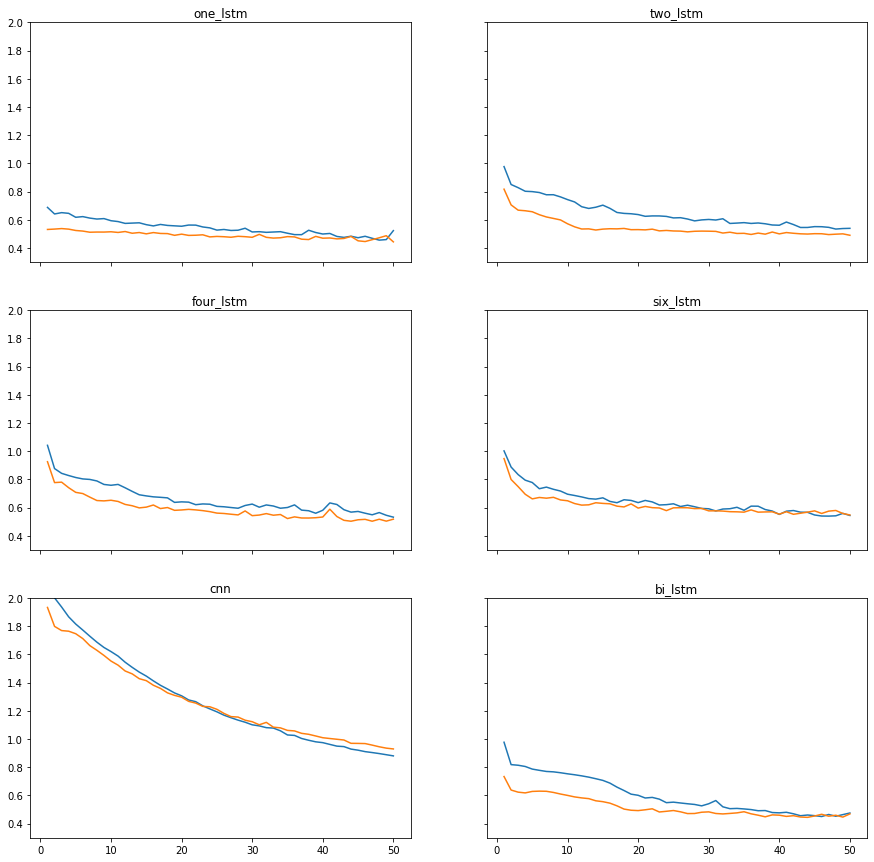

In [ ]:
f, ((ax2,ax4), (ax1,  ax6), (ax12,  ax10)) = plt.subplots(3,2, sharex='col', sharey='row',figsize=(15, 15))

plt.title('Training Vs Validation loss for all embeddings')


ax2.plot(epochRange,all_losses['one_lstm_loss'])
ax2.plot(epochRange,all_losses['one_lstm_val_loss'])
ax2.set_title('one_lstm')
ax2.set_ylim(0.3, 2)


ax4.plot(epochRange,all_losses['two_lstm_loss'])
ax4.plot(epochRange,all_losses['two_lstm_val_loss'])
ax4.set_title('two_lstm')
ax4.set_ylim(0.3, 2)

ax1.plot(epochRange,all_losses['four_lstm_loss'])
ax1.plot(epochRange,all_losses['four_lstm_val_loss'])
ax1.set_title('four_lstm')
ax1.set_ylim(0.3, 2)

ax6.plot(epochRange,all_losses['six_lstm_loss'])
ax6.plot(epochRange,all_losses['six_lstm_val_loss'])
ax6.set_title('six_lstm')
ax6.set_ylim(0.3, 2)


ax10.plot(epochRange,all_losses['bi_lstm_loss'])
ax10.plot(epochRange,all_losses['bi_lstm_val_loss'])
ax10.set_title('bi_lstm')
ax10.set_ylim(0.3, 2)


ax12.plot(epochRange,all_losses['cnn_loss'])
ax12.plot(epochRange,all_losses['cnn_val_loss'])
ax12.set_title('cnn')
ax12.set_ylim(0.3, 2)

plt.show()